<a href="https://colab.research.google.com/github/EvgSkv/virtual_people_examples/blob/main/notebooks/Adaptive_Dirac_Mixture_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Dirac Mixture Training

[evgskv@](https://github.com/evgskv)

This notebook implements and tests Adaptive Dirac Mixture training, it is described in Algorithm 4 in the paper [Measuring Cross-Device Online Audiences](https://research.google/pubs/pub45353/).

We then create synthetic panel data and verify that the trained ADF matches the synthetic observation well.

Code developed in this CoLab is [available at GitHub](https://github.com/world-federation-of-advertisers/virtual-people-training/tree/main/src/main/py/wfa/virtual_people/training/adf).

## Training code

### Fitting coefficients for the pre-specified deltas

In [ ]:
from scipy import optimize
import numpy
from matplotlib import pyplot


def fit_alphas(ds, signal, target):
  c = (1 - numpy.exp(- ds.dot(signal.T))).T
  result, _ = optimize.nnls(c, target, maxiter=1000)
  return result

class DiracMixture(object):
  def __init__(self, alphas, ds):
    self.alphas = alphas
    self.ds = ds
  
  def __call__(self, signal):
    return numpy.hstack(self.alphas).dot((1 - numpy.exp(- self.ds.dot(signal.T))))

# Testing by fitting a mixture of 2 deltas.
toy_signal = numpy.random.uniform(0, 1, (1000, 2))
toy_ds = numpy.array([[1.5, 0.5],
                      [0.5, 1.5]])
toy_alphas = numpy.array([0.2, 0.8])
toy_dm = DiracMixture(toy_alphas, numpy.array(toy_ds))
toy_target = toy_dm(toy_signal)
print('Fitted alphas:', fit_alphas(toy_ds, toy_signal, toy_target))


Fitted alphas: [0.2 0.8]


### Auxuliary function of sampling from a mixture of Gaussians

Text(0, 0.5, 'Mobile activity')

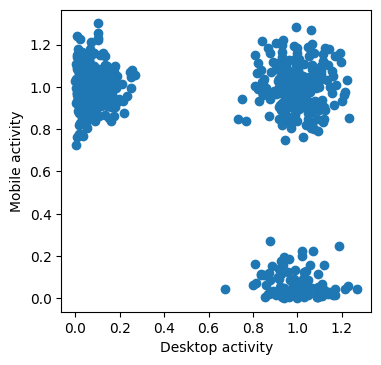

In [ ]:
def sampled_from_gaussian_mixture(centers, center_probabilities,
                                  num_new_centers, sigma):
  dim = centers.shape[1]
  new_centers = centers[numpy.random.choice(
      len(center_probabilities),
      num_new_centers,
      replace=True, p=center_probabilities)]
  noise = numpy.random.normal(0, sigma, (num_new_centers, dim))
  new_centers += noise
  min_coord = new_centers.min(axis=1)
  sum_coord = new_centers.sum(axis=1)
  new_centers = new_centers[(min_coord > 0) & (sum_coord > 0)]
  return new_centers

nc = sampled_from_gaussian_mixture(
    numpy.array([[1., 0.], [0., 1.], [1.,1.]]),
    numpy.array([0.2, 0.6, 0.2]),
    1000,
    0.1
)

pyplot.figure(dpi=100, figsize=(4, 4))
pyplot.scatter(nc[:, 0], nc[:, 1])
pyplot.xlabel('Desktop activity')
pyplot.ylabel('Mobile activity')

### Adaptive Dirac Mixture Fitting Function

In [ ]:
def fit_adaptive_dirac_mixture(signal, target,
                               new_centers_at_each_step=10,
                               new_centers_sigma=0.01,
                               max_steps=1000,
                               initial_centers=None,
                               iteration_callback=None):
  dim = signal.shape[1]
  centers = initial_centers or numpy.vstack([numpy.ones(dim)])
  alphas = numpy.ones(len(centers)) / len(centers)
  for i in range(max_steps):
    center_probabilities = alphas / sum(alphas)
    new_centers = sampled_from_gaussian_mixture(
        centers, center_probabilities,
        new_centers_at_each_step, new_centers_sigma)
    centers = numpy.vstack([centers, new_centers])
    alphas = fit_alphas(centers,
                        signal,
                        target)
    centers = centers[alphas > 0]
    alphas = alphas[alphas > 0]
    if iteration_callback:
      iteration_callback(i, alphas, centers)
  return alphas, centers

toy_signal = numpy.random.uniform(0, 1, (1000, 2))
toy_ds = [[1.5, 0.5],
          [0.5, 1.5]]
toy_alphas = numpy.ones(len(toy_ds)) / len(toy_ds)
toy_dm = DiracMixture(toy_alphas, numpy.array(toy_ds))
toy_target = toy_dm(toy_signal)

a, c = fit_adaptive_dirac_mixture(toy_signal, toy_target)

print('ADM=', ' + \n     '.join(
    "%.3f * %s" % (alpha, delta)
    for alpha, delta in zip(a, c)
))


ADM= 0.048 * [0.5006757 1.4990866] + 
     0.392 * [0.49994714 1.50011074] + 
     0.441 * [1.50006508 0.50000106] + 
     0.057 * [0.49976549 1.50004132] + 
     0.042 * [1.49950221 0.49978229] + 
     0.002 * [0.50083326 1.49908881] + 
     0.018 * [1.49955089 0.50048711]


### Creating an animation of ADM search

In [ ]:
import imageio

toy_signal = numpy.random.uniform(0, 1, (1000, 2))
toy_ds = [[1.5, 1.5],
          [0.5, 1.5],
          [0.4, 0.6],
          [0.6, 0.4],
          [0.8, 0.2],
          [1.0, 0.2],
          [1.2, 0.2],
          [1.4, 0.4],
          [1.6, 0.6]]
toy_alphas = numpy.ones(len(toy_ds)) / len(toy_ds)
toy_dm = DiracMixture(toy_alphas, numpy.array(toy_ds))
toy_target = toy_dm(toy_signal)

writer = imageio.get_writer('adm_search.gif', mode='I')

def add_frame(i, alphas, ds):
  if i % 10 == 0:
    if i % 100 == 0:
      print('iteration %d' % i)
    pyplot.figure()
    pyplot.xlabel('desktop activity')
    pyplot.ylabel('mobile activity')
    pyplot.title('Activity Density')
    pyplot.scatter(ds[:, 0], ds[:, 1])
    pyplot.xlim(0, 2)
    pyplot.ylim(0, 2)
    filename = 'step_%d.png' % i
    pyplot.savefig(filename)
    pyplot.close()

    writer.append_data(imageio.imread(filename))

fit_adaptive_dirac_mixture(
    toy_signal, toy_target,
    max_steps=1000,
    iteration_callback=add_frame)
writer.close()

from google.colab import files

files.download('adm_search.gif')

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[Doc with the GIF](https://docs.google.com/document/d/1QeFWgUKPxiCuRTaKl-BjYdG1zKOj0ya7X1x_WC_jEok/edit?usp=sharing) like the one generated above.

### Wrapping fitting algorithm into a class

Finally wrapping the ADM training into a class.

In [ ]:
class AdaptiveDiracMixture(DiracMixture):
  def __init__(self):
    self.alphas = None
    self.ds = None
  
  def fit(self, signal, target,
          new_centers_at_each_step=10,
          new_centers_sigma=0.01,
          max_steps=1000,
          initial_centers=None,
          iteration_callback=None):
    self.alphas, self.ds = fit_adaptive_dirac_mixture(
        signal, target,
        new_centers_at_each_step=10,
        new_centers_sigma=0.01,
        max_steps=1000,
        initial_centers=None,
        iteration_callback=None)
    
toy_signal = numpy.random.uniform(0, 1, (1000, 2))
toy_ds = [[1.5, 0.5],
          [0.5, 1.5]]
toy_alphas = numpy.ones(len(toy_ds)) / len(toy_ds)
toy_dm = DiracMixture(toy_alphas, numpy.array(toy_ds))
toy_target = toy_dm(toy_signal)

adm = AdaptiveDiracMixture()
adm.fit(toy_signal, toy_target, max_steps=10)
print('ADM=', ' + \n     '.join(
    "%.3f * %s" % (alpha, delta)
    for alpha, delta in zip(adm.alphas, adm.ds)
))


ADM= 0.244 * [0.50026098 1.4996776 ] + 
     0.414 * [1.49993748 0.50000773] + 
     0.055 * [1.50018272 0.5001818 ] + 
     0.031 * [1.50050649 0.49957717] + 
     0.250 * [0.4997332  1.50031398] + 
     0.006 * [0.50049068 1.50003475]


## Generating Synthetic Data

Next we generate synthetic log data to test ADM on input with somwhat realistic noise.

In [ ]:
!pip install logica

     |████████████████████████████████| 80 kB 3.4 MB/s 


In [ ]:
from logica import colab_logica

colab_logica.SetPreamble('@Dataset("omadf");');

### Auxiliary functions for random numbers generation

In [ ]:
%%writefile random.l

MaxInt() = 9223372036854775807;
IntHash(x) = Abs(FarmFingerprint("float_hash:" ++ ToString(x)));
FloatHash(x) = IntHash(x) / MaxInt();

# Random number uniformly distributed between 0 and 1.
RandomUniform(seed) = FarmFingerprint(ToString(seed)) / MaxUInt64();

# Random number from Pareto Type II distribution with shape a and mean 1.
# https://en.wikipedia.org/wiki/Lomax_distribution
RandomPareto(seed, a) = (a - 1) * (1 - p) / p :-
  x == FloatHash(seed),
  p == Pow(x, 1 / a);

ConsistentHash(x, weighted_options) --> result :-
  result ArgMax= (
      option.name -> xi :-
      option in weighted_options,
      xi == Log(
          FloatHash("xi:" ++ ToString(x) ++ ToString(option.name))) /
          option.weight
  );


Writing random.l


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at ConsistentHashTest_sql variable.
CREATE TEMP FUNCTION random_ConsistentHash(x ANY TYPE, weighted_options ANY TYPE) AS ((SELECT
  ARRAY_AGG(x_31.name order by  [((LOG(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT((CONCAT("xi:", CAST(x AS STRING))), CAST(x_31.name AS STRING))) AS STRING)))))) / (9223372036854775807)))) / (x_31.weight))][offset(0)] desc limit 1)[OFFSET(0)] AS logica_value
FROM
  UNNEST(weighted_options) as x_31));

SELECT
  random_ConsistentHash(x_1, ARRAY[STRUCT("A" AS name, 1.0 AS weight), STRUCT("B" AS name, 2.0 AS weight)]) AS col0,
  SUM(1) AS logica_value
FROM
  UNNEST(GENERATE_ARRAY(0, 30000 - 1)) as x_1
GROUP BY col0;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

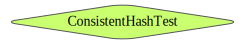

Running predicate: ConsistentHashTest
Please enter project_id to use for BigQuery querries.
active-grp
project_id is set to active-grp
You can change it with logica.colab_logica.SetProject command.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at ConsistentHashTest variable.


,col0,logica_value
0,B,20021
1,A,9979


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%logica ConsistentHashTest

import random.ConsistentHash;

ConsistentHashTest(option) += 1 :-
  option == ConsistentHash(seed, [{name: "A", weight: 1.0},
                                  {name: "B", weight: 2.0}]),
  seed in Range(30000);


### Generating synthetic log data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at CampaignSize_sql variable.
SELECT
  x_3 AS col0,
  ((2000) * (((((((3.0) - (1))) * (((((1) - (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_3 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))) / (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_3 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))))) + (0.1)))) AS logica_value
FROM
  UNNEST(GENERATE_ARRAY(0, 1000 - 1)) as x_3
WHERE
  (((2000) * (((((((3.0) - (1))) * (((((1) - (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_3 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))) / (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_3 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))))) + (0.1)))) < 20000);


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at CampaignCookieReach_sql variable.
SELECT
  x_15 AS campaign,
  ((((2000) * (((((((3.0) - (1))) * (((((1) - (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_15 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))) / (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_15 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))))) + (0.1))))) * (((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST(x_15 AS STRING)))))) / (9223372036854775807)))) AS desktop,
  ((((2000) * (((((((3.0) - (1))) * (((((1) - (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_22 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))) / (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_22 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))))) + (0.1))))) - (((((2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at NumVisits_sql variable.
DROP TABLE IF EXISTS omadf.CampaignCookieReach;
CREATE TABLE omadf.CampaignCookieReach AS SELECT
  x_17 AS campaign,
  ((((2000) * (((((((3.0) - (1))) * (((((1) - (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_17 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))) / (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_17 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))))) + (0.1))))) * (((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST(x_17 AS STRING)))))) / (9223372036854775807)))) AS desktop,
  ((((2000) * (((((((3.0) - (1))) * (((((1) - (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_24 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))) / (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_24 AS STRING))) AS

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at SaveSyntheticLog_sql variable.
DROP TABLE IF EXISTS omadf.CampaignCookieReach;
CREATE TABLE omadf.CampaignCookieReach AS SELECT
  x_27 AS campaign,
  ((((2000) * (((((((3.0) - (1))) * (((((1) - (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_27 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))) / (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_27 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))))) + (0.1))))) * (((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST(x_27 AS STRING)))))) / (9223372036854775807)))) AS desktop,
  ((((2000) * (((((((3.0) - (1))) * (((((1) - (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_34 AS STRING))) AS STRING)))))) / (9223372036854775807)), ((1) / (3.0)))))) / (POW(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("campaign-size-", CAST(x_34 AS STRIN

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

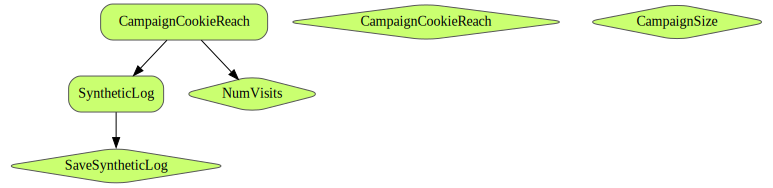

Running predicate: CampaignCookieReach
Running predicate: ⤓CampaignCookieReach
Running predicate: CampaignSize
Running predicate: SyntheticLog
Running predicate: SaveSyntheticLog
Running predicate: NumVisits


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at CampaignSize variable.


,col0,logica_value
0,0,3591.966944
1,1,2151.024511
2,2,329.169881
3,3,592.343648
4,4,567.701629
...,...,...
993,995,3313.501300
994,996,1680.167769
995,997,845.162677
996,998,1791.266872


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at CampaignCookieReach variable.


,campaign,desktop,mobile
0,0,351.646479,3240.320464
1,1,2038.013733,113.010778
2,2,171.183034,157.986847
3,3,418.765835,173.577813
4,4,195.645284,372.056345
...,...,...,...
993,995,1499.998615,1813.502685
994,996,590.330708,1089.837061
995,997,766.912699,78.249978
996,998,741.357180,1049.909693


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at NumVisits variable.


,logica_value
0,2.104945e+06


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at SaveSyntheticLog variable.


,logica_value
0,2103942


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%logica CampaignSize,CampaignCookieReach,NumVisits,SaveSyntheticLog

import random.RandomPareto;
import random.FloatHash;
import random.IntHash;

CampaignSize(i) = size :-
  seed == "campaign-size-" ++ ToString(i),
  size == 2000 * (RandomPareto(seed, 3.0) + 0.1),
  i in Range(1000),
  size < 20000;

@Ground(CampaignCookieReach);
CampaignCookieReach(campaign: i, desktop:, mobile:) :-
  desktop == CampaignSize(i) * desktop_fraction,
  mobile == CampaignSize(i) - desktop,
  seed == "campaign-split-" ++ ToString(i),
  desktop_fraction == FloatHash(i);

NumVisits() += desktop + mobile :-
  CampaignCookieReach(desktop:, mobile:);

@Ground(SyntheticLog);
SyntheticLog(user_id:, campaign:, device:) :-
  device in ["desktop", "mobile"],
  CampaignCookieReach(campaign:, desktop:, mobile:),
  num_users == (
      if device == "desktop" then
        desktop
      else
        mobile
  ),
  mobile_offset == (
      if device == "desktop" then
        0
      else
        50000
  ),
  i in Range(num_users),
  user_id == IntHash("random_visitor" ++ ToString(i)) % 50000 + mobile_offset;

SaveSyntheticLog() += 1 :- SyntheticLog();


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at LogCampaignSizes_sql variable.
-- Interacting with table omadf.SyntheticLog

SELECT
  SyntheticLog.campaign AS col0,
  APPROX_COUNT_DISTINCT(SyntheticLog.user_id) AS logica_value
FROM
  omadf.SyntheticLog AS SyntheticLog
GROUP BY col0;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

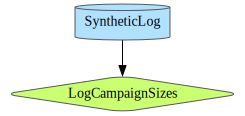

Running predicate: LogCampaignSizes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at LogCampaignSizes variable.


,col0,logica_value
0,3,591
1,28,1350
2,52,8822
3,84,1506
4,115,1458
...,...,...
993,828,1306
994,930,2142
995,960,3077
996,969,483


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%logica LogCampaignSizes

@Ground(SyntheticLog);

LogCampaignSizes(campaign) Count= user_id :-
  SyntheticLog(campaign:, user_id:);

Text(0, 0.5, 'Campaign count')

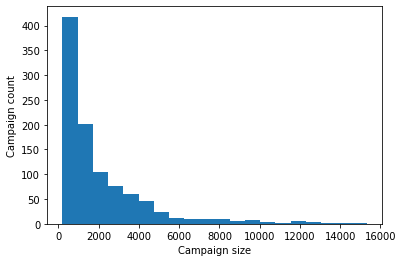

In [ ]:
pyplot.hist(LogCampaignSizes['logica_value'], bins=20)
pyplot.xlabel('Campaign size')
pyplot.ylabel('Campaign count')

### Extending synthetic log data with a  person id

In [ ]:
%%writefile dirac_mixture.l

import random.ConsistentHash;
import random.FloatHash;

IdType(id_type) distinct :-
  MaterialDiracDelta(activity:),
  a in activity,
  id_type == a.id_type;

MaterialDiracDelta(
    idx: 0, activity: [{id_type: "desktop", d: 1.5},
                       {id_type: "mobile", d: 0.5}],
    people_offset: 10000, people_total: 2000);

MaterialDiracDelta(
    idx: 1, activity: [{id_type: "desktop", d: 0.5},
                       {id_type: "mobile", d: 1.5}],
    people_offset: 20000, people_total: 2000);

DistributionForIdType(
    id_type:,
    idx:,
    weight:,
    people_offset:,
    people_total:) :-
  IdType(id_type),
  MaterialDiracDelta(idx:, activity:, people_offset:, people_total:),
  a in activity,
  a.id_type == id_type,
  weight == a.d * people_total;

PickDiracDelta(seed, id_type) = delta_idx :-
  options List= ({name: idx,
                  weight:} :- DistributionForIdType(idx:, weight:, id_type:)),
  delta_idx == ConsistentHash(seed, options);

SampleFromDelta(seed, id_type, idx) = person :-
  person == people_offset + ToInt64(
      FloatHash("person-" ++ ToString(seed)) * people_total),
  DistributionForIdType(id_type:, idx:, people_offset:, people_total:);


Writing dirac_mixture.l


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at Q_sql variable.
WITH t_2_dirac_mixture_MaterialDiracDelta AS (SELECT * FROM (
  
    SELECT
      0 AS idx,
      ARRAY[STRUCT("desktop" AS id_type, 1.5 AS d), STRUCT("mobile" AS id_type, 0.5 AS d)] AS activity,
      10000 AS people_offset,
      2000 AS people_total
   UNION ALL
  
    SELECT
      1 AS idx,
      ARRAY[STRUCT("desktop" AS id_type, 0.5 AS d), STRUCT("mobile" AS id_type, 1.5 AS d)] AS activity,
      20000 AS people_offset,
      2000 AS people_total
  
) AS UNUSED_TABLE_NAME  ),
t_0_dirac_mixture_IdType AS (SELECT
  x_13.id_type AS col0
FROM
  t_2_dirac_mixture_MaterialDiracDelta AS t_1_dirac_mixture_MaterialDiracDelta, UNNEST(t_1_dirac_mixture_MaterialDiracDelta.activity) as x_13
GROUP BY col0)
SELECT
  dirac_mixture_IdType.col0 AS id_type,
  dirac_mixture_MaterialDiracDelta.idx AS idx,
  ((x_10.d) * (dirac_mixture_MaterialDiracDelta.people_total)) AS weight,
  dirac_mixture_MaterialDiracDelta.people_offset AS people_offset,
  dirac_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at S_sql variable.
CREATE TEMP FUNCTION random_ConsistentHash(x ANY TYPE, weighted_options ANY TYPE) AS ((SELECT
  ARRAY_AGG(x_31.name order by  [((LOG(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT((CONCAT("xi:", CAST(x AS STRING))), CAST(x_31.name AS STRING))) AS STRING)))))) / (9223372036854775807)))) / (x_31.weight))][offset(0)] desc limit 1)[OFFSET(0)] AS logica_value
FROM
  UNNEST(weighted_options) as x_31));

WITH t_2_dirac_mixture_MaterialDiracDelta AS (SELECT * FROM (
  
    SELECT
      0 AS idx,
      ARRAY[STRUCT("desktop" AS id_type, 1.5 AS d), STRUCT("mobile" AS id_type, 0.5 AS d)] AS activity,
      10000 AS people_offset,
      2000 AS people_total
   UNION ALL
  
    SELECT
      1 AS idx,
      ARRAY[STRUCT("desktop" AS id_type, 0.5 AS d), STRUCT("mobile" AS id_type, 1.5 AS d)] AS activity,
      20000 AS people_offset,
      2000 AS people_total
  
) AS UNUSED_TABLE_NAME  ),
t_0_dirac_mixture_IdType AS (SELECT
  x_30.id_type 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at Stats_sql variable.
CREATE TEMP FUNCTION random_ConsistentHash(x ANY TYPE, weighted_options ANY TYPE) AS ((SELECT
  ARRAY_AGG(x_31.name order by  [((LOG(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT((CONCAT("xi:", CAST(x AS STRING))), CAST(x_31.name AS STRING))) AS STRING)))))) / (9223372036854775807)))) / (x_31.weight))][offset(0)] desc limit 1)[OFFSET(0)] AS logica_value
FROM
  UNNEST(weighted_options) as x_31));

WITH t_2_dirac_mixture_MaterialDiracDelta AS (SELECT * FROM (
  
    SELECT
      0 AS idx,
      ARRAY[STRUCT("desktop" AS id_type, 1.5 AS d), STRUCT("mobile" AS id_type, 0.5 AS d)] AS activity,
      10000 AS people_offset,
      2000 AS people_total
   UNION ALL
  
    SELECT
      1 AS idx,
      ARRAY[STRUCT("desktop" AS id_type, 0.5 AS d), STRUCT("mobile" AS id_type, 1.5 AS d)] AS activity,
      20000 AS people_offset,
      2000 AS people_total
  
) AS UNUSED_TABLE_NAME  ),
t_0_dirac_mixture_IdType AS (SELECT
  x_35.id_t

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at SampleFromDeltaTest_sql variable.
WITH t_2_dirac_mixture_MaterialDiracDelta AS (SELECT * FROM (
  
    SELECT
      0 AS idx,
      ARRAY[STRUCT("desktop" AS id_type, 1.5 AS d), STRUCT("mobile" AS id_type, 0.5 AS d)] AS activity,
      10000 AS people_offset,
      2000 AS people_total
   UNION ALL
  
    SELECT
      1 AS idx,
      ARRAY[STRUCT("desktop" AS id_type, 0.5 AS d), STRUCT("mobile" AS id_type, 1.5 AS d)] AS activity,
      20000 AS people_offset,
      2000 AS people_total
  
) AS UNUSED_TABLE_NAME  ),
t_0_dirac_mixture_IdType AS (SELECT
  x_38.id_type AS col0
FROM
  t_2_dirac_mixture_MaterialDiracDelta AS t_1_dirac_mixture_MaterialDiracDelta, UNNEST(t_1_dirac_mixture_MaterialDiracDelta.activity) as x_38
GROUP BY col0)
SELECT
  ((dirac_mixture_MaterialDiracDelta.people_offset) + (CAST(((((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT("person-", CAST(x_2 AS STRING))) AS STRING)))))) / (9223372036854775807))) * (dirac_mixture_Mater

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at UnderlyingDiracMixture_sql variable.
WITH t_0_dirac_mixture_MaterialDiracDelta AS (SELECT * FROM (
  
    SELECT
      0 AS idx,
      ARRAY[STRUCT("desktop" AS id_type, 1.5 AS d), STRUCT("mobile" AS id_type, 0.5 AS d)] AS activity,
      10000 AS people_offset,
      2000 AS people_total
   UNION ALL
  
    SELECT
      1 AS idx,
      ARRAY[STRUCT("desktop" AS id_type, 0.5 AS d), STRUCT("mobile" AS id_type, 1.5 AS d)] AS activity,
      20000 AS people_offset,
      2000 AS people_total
  
) AS UNUSED_TABLE_NAME  ),
t_1_Population AS (SELECT
  SUM(t_2_dirac_mixture_MaterialDiracDelta.people_total) AS logica_value
FROM
  t_0_dirac_mixture_MaterialDiracDelta AS t_2_dirac_mixture_MaterialDiracDelta)
SELECT
  (SELECT
  ANY_VALUE(x_9.d) AS logica_value
FROM
  UNNEST(dirac_mixture_MaterialDiracDelta.activity) as x_9
WHERE
  (x_9.id_type = "desktop")) AS desktop_activity,
  (SELECT
  ANY_VALUE(x_10.d) AS logica_value
FROM
  UNNEST(dirac_mixture_MaterialDirac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

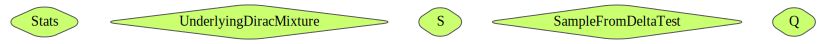

Running predicate: Stats
Running predicate: UnderlyingDiracMixture
Running predicate: S
Running predicate: SampleFromDeltaTest
Running predicate: Q


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at Q variable.


,id_type,idx,weight,people_offset,people_total
0,desktop,0,3000.0,10000,2000
1,desktop,1,1000.0,20000,2000
2,mobile,0,1000.0,10000,2000
3,mobile,1,3000.0,20000,2000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at S variable.


,col0,col1,col2
0,0,mobile,1
1,0,desktop,0
2,1,mobile,1
3,1,desktop,1
4,2,mobile,0
...,...,...,...
19995,9997,desktop,0
19996,9998,mobile,1
19997,9998,desktop,0
19998,9999,mobile,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at Stats variable.


,col0,col1,logica_value
0,mobile,1,7536
1,mobile,0,2464
2,desktop,0,7450
3,desktop,1,2550


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at SampleFromDeltaTest variable.


,col0
0,20124
1,21068
2,20018
3,21519
4,20095
...,...
995,20737
996,20714
997,21284
998,20825


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at UnderlyingDiracMixture variable.


,desktop_activity,mobile_activity,alpha
0,1.5,0.5,0.5
1,0.5,1.5,0.5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%logica Q, S, Stats, SampleFromDeltaTest, UnderlyingDiracMixture

import dirac_mixture.DistributionForIdType;
import dirac_mixture.PickDiracDelta;
import dirac_mixture.SampleFromDelta;
import dirac_mixture.MaterialDiracDelta;

Q := DistributionForIdType();

S(seed, id_type, PickDiracDelta(seed, id_type)) :-
  seed in Range(10000),
  id_type in ["mobile", "desktop"];

Stats(id_type, idx) += 1 :-
  S(seed, id_type, idx);

SampleFromDeltaTest(person) :-
  person == SampleFromDelta(i, "mobile", 1),
  i in Range(1000);

Population() += people_total :- MaterialDiracDelta(people_total:);

UnderlyingDiracMixture(desktop_activity:, mobile_activity:, alpha:) :-
  MaterialDiracDelta(activity:, people_total:),
  alpha == people_total / Population(),
  desktop_activity AnyValue= (a.d :- a in activity, a.id_type == "desktop"),
  mobile_activity AnyValue= (a.d :- a in activity, a.id_type == "mobile");


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at SaveSyntheticLogWithPerson_sql variable.
CREATE TEMP FUNCTION random_ConsistentHash(x ANY TYPE, weighted_options ANY TYPE) AS ((SELECT
  ARRAY_AGG(x_31.name order by  [((LOG(((ABS(FARM_FINGERPRINT((CONCAT("float_hash:", CAST((CONCAT((CONCAT("xi:", CAST(x AS STRING))), CAST(x_31.name AS STRING))) AS STRING)))))) / (9223372036854775807)))) / (x_31.weight))][offset(0)] desc limit 1)[OFFSET(0)] AS logica_value
FROM
  UNNEST(weighted_options) as x_31));

-- Interacting with table omadf.SyntheticLog

DROP TABLE IF EXISTS omadf.SyntheticLogWithDelta;
CREATE TABLE omadf.SyntheticLogWithDelta AS WITH t_5_dirac_mixture_MaterialDiracDelta AS (SELECT * FROM (
  
    SELECT
      0 AS idx,
      ARRAY[STRUCT("desktop" AS id_type, 1.5 AS d), STRUCT("mobile" AS id_type, 0.5 AS d)] AS activity,
      10000 AS people_offset,
      2000 AS people_total
   UNION ALL
  
    SELECT
      1 AS idx,
      ARRAY[STRUCT("desktop" AS id_type, 0.5 AS d), STRUCT("mobile" AS id_typ

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

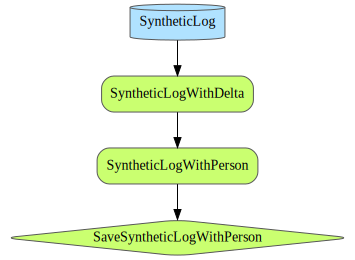

Running predicate: SyntheticLogWithDelta
Running predicate: SyntheticLogWithPerson
Running predicate: SaveSyntheticLogWithPerson


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at SaveSyntheticLogWithPerson variable.


,logica_value
0,2103942


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%logica SaveSyntheticLogWithPerson

import dirac_mixture.PickDiracDelta;
import dirac_mixture.SampleFromDelta;

@Ground(SyntheticLog);

@Ground(SyntheticLogWithDelta);
SyntheticLogWithDelta(user_id:, campaign:, device:, delta_idx:) :-
  SyntheticLog(user_id:, campaign:, device:),
  delta_idx == PickDiracDelta(user_id, device);

@Ground(SyntheticLogWithPerson);
SyntheticLogWithPerson(user_id:, campaign:, device:, delta_idx:,
                       person:) :-
  SyntheticLogWithDelta(user_id:, campaign:, device:, delta_idx:),
  person == SampleFromDelta(user_id, device, delta_idx);

SaveSyntheticLogWithPerson() += 1 :-
  SyntheticLogWithPerson();


### Verifying that people counts look roughly as expected

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at LogCampaignReach_sql variable.
-- Interacting with table omadf.SyntheticLogWithPerson

SELECT
  SyntheticLogWithPerson.campaign AS campaign,
  APPROX_COUNT_DISTINCT(CASE WHEN (SyntheticLogWithPerson.device = "desktop") THEN SyntheticLogWithPerson.user_id ELSE null END) AS desktop_userid_reach,
  APPROX_COUNT_DISTINCT(CASE WHEN (SyntheticLogWithPerson.device = "mobile") THEN SyntheticLogWithPerson.user_id ELSE null END) AS mobile_userid_reach,
  APPROX_COUNT_DISTINCT(SyntheticLogWithPerson.user_id) AS userid_reach,
  APPROX_COUNT_DISTINCT(SyntheticLogWithPerson.person) AS people_reach
FROM
  omadf.SyntheticLogWithPerson AS SyntheticLogWithPerson
GROUP BY campaign;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

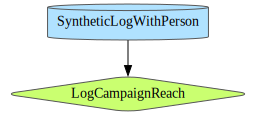

Running predicate: LogCampaignReach


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at LogCampaignReach variable.


,campaign,desktop_userid_reach,mobile_userid_reach,userid_reach,people_reach
0,461,167,9890,10059,3420
1,402,4841,7974,12819,3840
2,358,496,1979,2476,1800
3,73,7087,2384,9472,3575
4,897,81,3029,3111,2047
...,...,...,...,...,...
993,235,52,185,237,233
994,982,38,285,323,311
995,377,63,142,205,202
996,441,66,197,263,258


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%logica LogCampaignReach

@Ground(SyntheticLogWithPerson);

LogCampaignReach(campaign:,
                 desktop_userid_reach? Count= desktop_user_id,
                 mobile_userid_reach? Count= mobile_user_id,
                 userid_reach? Count= user_id,
                 people_reach? Count= person) distinct :-
  SyntheticLogWithPerson(campaign:, user_id:, person:, device:),
  desktop_user_id == (
      if device == "desktop" then
        user_id
      else
        null
  ),
  mobile_user_id == (
      if device == "mobile" then
        user_id
      else
        null
  );


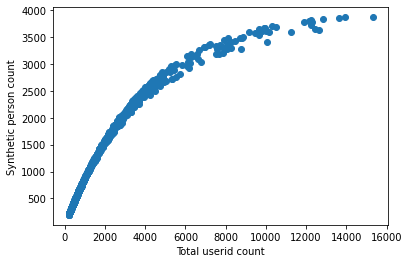

In [ ]:
pyplot.scatter(LogCampaignReach['userid_reach'],
               LogCampaignReach['people_reach'])
pyplot.xlabel('Total userid count')
pyplot.ylabel('Synthetic person count')

synthetic_signal = LogCampaignReach[['desktop_userid_reach',
                                     'mobile_userid_reach']] / 4000
synthetic_target = LogCampaignReach['people_reach'] / 4000



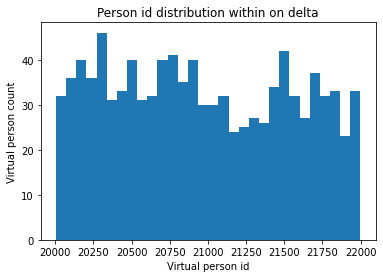

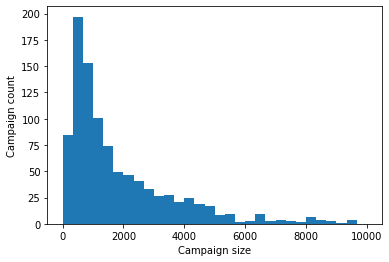

In [ ]:
from matplotlib import pyplot

pyplot.figure()
_ = pyplot.hist(SampleFromDeltaTest['col0'], bins=30)
pyplot.title('Person id distribution within on delta')
pyplot.xlabel('Virtual person id')
pyplot.ylabel('Virtual person count')

pyplot.figure()
_ = pyplot.hist(CampaignSize['logica_value'], bins=30, range=(0,10000))
_ = pyplot.xlabel('Campaign size')
_ = pyplot.ylabel('Campaign count')

### Fitting ADM to synthetic log data, checking accuracy of prediction

ADM= 0.006 * [1.89797232e+00 5.04515825e-04] + 
     0.132 * [0.28668347 1.8128389 ] + 
     0.029 * [1.89103061e+00 8.29170348e-04] + 
     0.391 * [1.29018098 0.68647595] + 
     0.269 * [1.29047369 0.68579542] + 
     0.079 * [0.28811949 1.81068256] + 
     0.099 * [0.28616928 1.81314162]


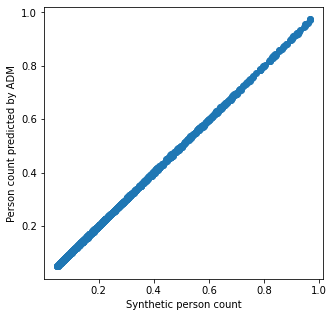

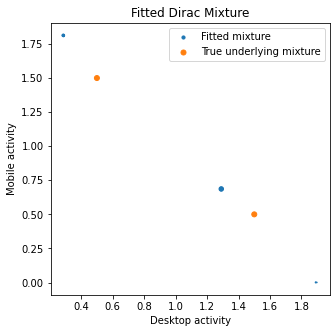

In [ ]:
adm = AdaptiveDiracMixture()
adm.fit(synthetic_signal, synthetic_target)

predicted_target = adm(synthetic_signal)
pyplot.figure(figsize=(5,5))
pyplot.scatter(synthetic_target, predicted_target,)
pyplot.xlabel('Synthetic person count')
pyplot.ylabel('Person count predicted by ADM')

pyplot.figure(figsize=(5,5))
pyplot.scatter(adm.ds[:, 0], adm.ds[:, 1], s=adm.alphas * 50,
               label='Fitted mixture')
pyplot.scatter(UnderlyingDiracMixture['desktop_activity'],
               UnderlyingDiracMixture['mobile_activity'],
               s=UnderlyingDiracMixture['alpha'] * 50,
               label='True underlying mixture')
pyplot.title('Fitted Dirac Mixture')
pyplot.xlabel('Desktop activity')
pyplot.ylabel('Mobile activity')
pyplot.legend(loc='best')


print('ADM=', ' + \n     '.join(
    "%.3f * %s" % (alpha, delta)
    for alpha, delta in zip(adm.alphas, adm.ds)
))

We observe that trained mixture did not converge to the exact underlying one, but high prediction accuracy on synthetic data was achieved.